#  cf wavelet function

In [ ]:
# Input : un dataframe ( comme df_train)
# Output :un dataframe de même taille ; chaque canal de couleur contient les détails obtenus 
#lors de la décomposition en ondelettes   : 30 minutes pour 5000 images

In [1]:
%pylab inline
import pandas
import cvxopt
import time
import numpy as np
import numpy.linalg as la
import scipy
from scipy.stats import mode
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Importation de données

In [3]:
df_train=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Xtr.csv',header=None,sep=',')
df_train=df_train.drop(3072,1)
df_test=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Xte.csv',header=None,sep=',')
df_test=df_test.drop(3072,1)
y_train=pandas.read_csv('/Users/philippe/Documents/MVA/kernel/kaggle/data/Ytr.csv',sep=',')
y_train=pandas.DataFrame(y_train['Prediction'])

In [4]:
y_train.head()

,Prediction
0,8
1,9
2,3
3,1
4,4


# Une premiere visualisation

In [5]:
df_train.shape

(5000, 3072)

(32, 32, 3)

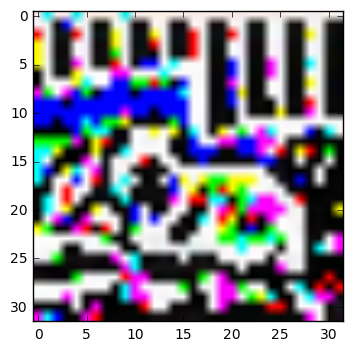

In [6]:
img = df_train.iloc[9,:].values.reshape(3,32,32).transpose(1,2,0)
plt.imshow(img) #, cmap=cm.gray)
img.shape

# code wavelets

In [14]:
def length(x=0):

    import numpy as np
    l = np.max(np.shape(x))
    return l

################# 1D convolution	

def filter_1d(xin=0,h=0,boption=3):

    import numpy as np
    import scipy.linalg as lng
    import copy as cp    
    
    x = np.squeeze(cp.copy(xin));
    n = length(x);
    m = length(h);
    y = cp.copy(x);

    z = np.zeros(1,m);

    for r in range(np.int(np.int(m/2))):
                
        if boption == 1: # --- zero padding
                        
            z = np.concatenate([np.zeros(m-r-np.int(m/2)-1),x[0:r+np.int(m/2)+1]],axis=0)
        
        if boption == 2: # --- periodicity
            
            z = np.concatenate([x[n-(m-(r+np.int(m/2)))+1:n],x[0:r+np.int(m/2)+1]],axis=0)
        
        if boption == 3: # --- mirror
            
            u = x[0:m-(r+np.int(m/2))-1];
            u = u[::-1]
            z = np.concatenate([u,x[0:r+np.int(m/2)+1]],axis=0)
                                     
        y[r] = np.sum(z*h)
        
        
    

    a = np.arange(np.int(np.int(m/2)),np.int(n-m+np.int(m/2)),1)

    for r in a:
        
        y[r] = np.sum(h*x[r-np.int(m/2):m+r-np.int(m/2)])
    

    a = np.arange(np.int(n-m+np.int(m/2)+1),n,1)

    for r in a:
            
        if boption == 1: # --- zero padding
            
            z = np.concatenate([x[r-np.int(m/2):n],np.zeros(m - (n-r) - np.int(m/2))],axis=0)
        
        if boption == 2: # --- periodicity
            
            z = np.concatenate([x[r-np.int(m/2):n],x[0:m - (n-r) - np.int(m/2)]],axis=0)
        
        if boption == 3: # --- mirror
                        
            u = x[n - (m - (n-r) - np.int(m/2) -1)-1:n]
            u = u[::-1]
            z = np.concatenate([x[r-np.int(m/2):n],u],axis=0)
                    
        y[r] = np.sum(z*h)
    	
    return y


In [15]:
################# 1D convolution with the "a trous" algorithm	

def Apply_H1(x=0,h=0,scale=1,boption=3):

	import numpy as np
	import copy as cp
	
	m = length(h)
	
	if scale > 1:
		p = (m-1)*np.power(2,(scale-1)) + 1
		g = np.zeros( p)
		z = np.linspace(0,m-1,m)*np.power(2,(scale-1))
		g[z.astype(int)] = h
	
	else:
		g = h
				
	y = filter_1d(x,g,boption)
	
	return y
	

In [16]:
################# 2D "a trous" algorithm

def Starlet_Forward(x=0,h=[0.0625,0.25,0.375,0.25,0.0625],J=1,boption=3):

	import numpy as np
	import copy as cp
	
	nx = np.shape(x)
	c = np.zeros((nx[0],nx[1]))
	w = np.zeros((nx[0],nx[1],J))

	c = cp.copy(x)
	cnew = cp.copy(x)
	
	for scale in range(J):
		
		for r in range(nx[0]):
			
			cnew[r,:] = Apply_H1(c[r,:],h,scale,boption)
			
		for r in range(nx[1]):
		
			cnew[:,r] = Apply_H1(cnew[:,r],h,scale,boption)
			
		w[:,:,scale] = c - cnew;
		
		c = cp.copy(cnew);

	return c,w
	

In [17]:
    
	################# 2D "a trous" algorithm

def Starlet_Inverse(c=0,w=0):

	import numpy as np
	
	x = c+np.sum(w,axis=2)

	return x

In [ ]:
def extract_detail(img,k) :
    boption=2
    h = 1/16*np.array([1,4,6,4,1])
    J = 3
    c,w =Starlet_Forward(img[:,:,k],h,J,boption)
    return w[:,:,0].flatten()

In [ ]:
def return_base(img):
    res=np.empty([3,1024])
    for k in range(3):
        res[k,:]=extract_detail(img,k)
    return res.flatten()    

In [ ]:
def wavelet(df_train):
    n_sample=df_train.shape[1]
    df_bis=np.empty(df_train.shape)
    for nb_im in range(n_sample):
        img=df_train.iloc[nb_im,:].values.reshape(3,32,32).transpose(1,2,0)
        df_bis[nb_im,:]=return_base(img)
    return pandas.DataFrame(df_bis)  

# Test

In [98]:
img = df_train.iloc[9,:].values.reshape(3,32,32).transpose(1,2,0)
boption=2
h = 1/16*np.array([1,4,6,4,1])
J = 3
c,w =Starlet_Forward(img[:,:,0],h,J,boption)

In [99]:
w[:,:,0].shape

(32, 32)

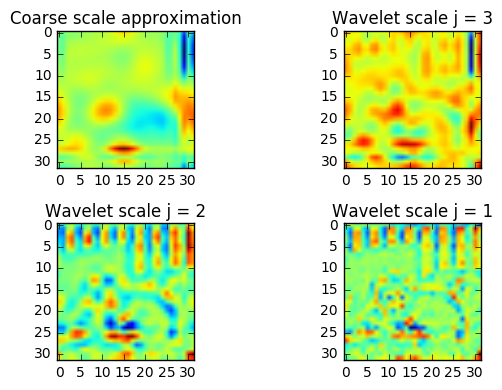

In [100]:
# Display the results
plt.figure(0)
plt.subplot(221)
plt.title('Coarse scale approximation')
plt.imshow(c)
plt.subplot(222)
plt.title('Wavelet scale j = 3')
plt.imshow(w[:,:,2])
plt.subplot(223)
plt.title('Wavelet scale j = 2')
plt.imshow(w[:,:,1])
plt.subplot(224)
plt.title('Wavelet scale j = 1')
plt.imshow(w[:,:,0])
plt.tight_layout()

In [101]:
xrec =Starlet_Inverse(c,w)

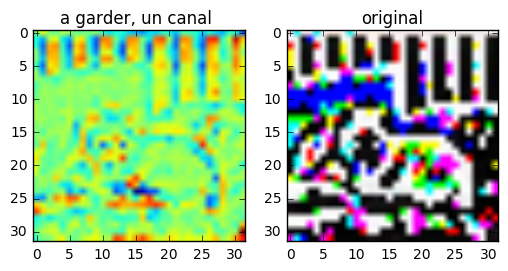

In [102]:
plt.subplot(121)
plt.imshow(w[:,:,0])
plt.title('a garder, un canal ')

plt.subplot(122)
plt.imshow(img)
plt.title('original')

In [81]:
import time
start = time.time()

n_sample=df_train.shape[1]
df_bis=np.empty(df_train.shape)
for nb_im in range(100):
    img=df_train.iloc[nb_im,:].values.reshape(3,32,32).transpose(1,2,0)
    df_bis[nb_im,:]=return_base(img)
    
end = time.time()
print(end - start)    

42.286569118499756


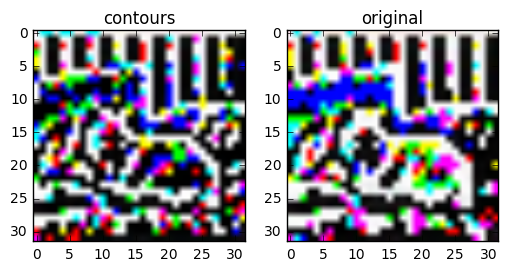

In [92]:
plt.subplot(121)
plt.imshow(img)
plt.title('contours')

plt.subplot(122)
plt.imshow(img_or) 
plt.title('original')

In [103]:
# Nous on pourrait garder contours